In [2]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from numba import njit
from tqdm import tqdm
import time
import multiprocessing
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import seaborn as sns
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern} \boldmath'

<>:261: SyntaxWarning: invalid escape sequence '\%'
<>:263: SyntaxWarning: invalid escape sequence '\%'
<>:261: SyntaxWarning: invalid escape sequence '\%'
<>:263: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_11921/57415237.py:261: SyntaxWarning: invalid escape sequence '\%'
  Line2D([0], [0], marker='o', color='w', label='50\% confidence interval',
/tmp/ipykernel_11921/57415237.py:263: SyntaxWarning: invalid escape sequence '\%'
  Line2D([0], [0], marker='s', color='w', label='90\% confidence interval',
/tmp/ipykernel_11921/57415237.py:133: RuntimeWarning: divide by zero encountered in divide
  freq_ns = np.where(spin_s_ns != 0, 1 / spin_s_ns, 0)


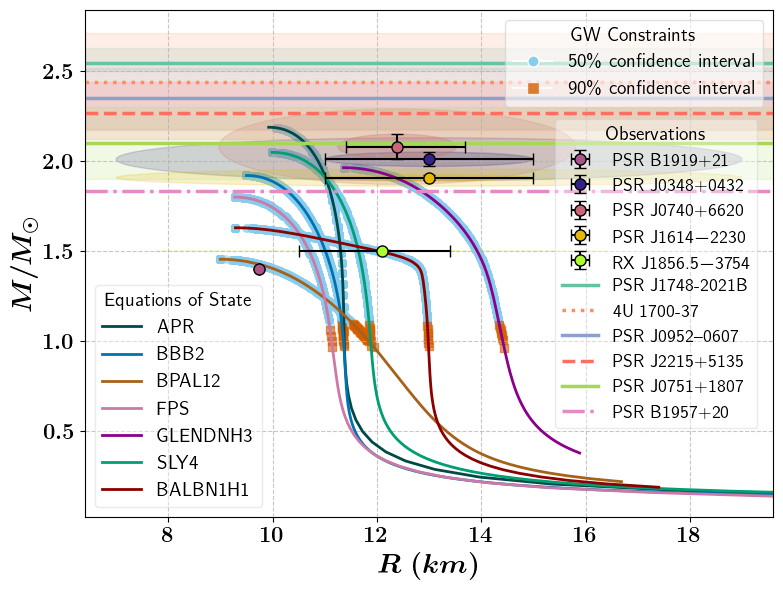

In [7]:
# Define eos_name names and colors
eos_names = ["apr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#009E73", "#8B0000"]

# Columns in MoIL.dat
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']
mass50, mass90 = [], []

# Extract masses from MoIL.dat using tidal deformability limits
for eos_name in eos_names:
    df = pd.read_csv(f'../output/{eos_name}/1000_MoIL.dat', names=cols)
    df = df.iloc[:df['M'].idxmax() + 1]

    for _, row in df.iterrows():
        if row['L'] <= 940.45:
            mass50.append(row['M'])
        elif 940.45 < row['L'] <= 1913.8:
            mass90.append(row['M'])

mass50 = np.array(mass50)
mass90 = np.array(mass90)


# Define Lorene data directory and eos_name mapping
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_300Hz_extracted_data.csv",
    "BBB2": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_300Hz_extracted_data.csv",
    "BPAL12": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_300Hz_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "GLENDNH3": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_300Hz_extracted_data.csv",
    "SLY4": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "BALBN1H1": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_300Hz_extracted_data.csv"
}

#cols = ["Gravitational mass", "Mean radius"]

mass50_nearest, mass90_nearest = {}, {}
radius50_nearest, radius90_nearest = {}, {}

# Folder path for LSODA results
lsoda_folder = "/home/sanjana/ashoka/thesis/output_lsoda"

plt.figure(figsize=(8, 6))
eos_handles = []
                           
# Loop over LSODA files in the folder and plot them
lsoda_markers = ["o", "o", "o", "o", "o", "o", "o"]  # Use the same markers
eos_names = ["apr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
    
# Iterate over the eos_names and construct the correct file names
for eos_name, marker, color in zip(eos_names, lsoda_markers, colors):
    # Construct the file name corresponding to each eos_name name
    lsoda_file = f"{eos_name}_cspline_LSODA.csv"
    
    # Construct the full path for each file
    file_path = os.path.join(lsoda_folder, lsoda_file)
    
    df_lsoda = pd.read_csv(file_path)
    
    # Assuming the columns are "Radius" and "Mass"
    # Filter out invalid values
    df_lsoda = df_lsoda[(df_lsoda["Radius (km)"] != "N/A") & (df_lsoda["Mass (M_sun)"] != "N/A")]
    df_lsoda["Radius (km)"] = pd.to_numeric(df_lsoda["Radius (km)"])
    df_lsoda["Mass (M_sun)"] = pd.to_numeric(df_lsoda["Mass (M_sun)"])

    # Filter out invalid entries (NaN values)
    df_lsoda = df_lsoda.dropna(subset=["Radius (km)", "Mass (M_sun)"])

    # Extract raw mass and radius values
    mass_values_raw = df_lsoda["Mass (M_sun)"].values
    radius_values_raw = df_lsoda["Radius (km)"].values

    # Apply the filtering logic to keep only increasing mass values
    valid_indices = [0]
    for i in range(1, len(mass_values_raw)):
        if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
            valid_indices.append(i)

    # Apply the filter to both mass and radius values
    mass_values = mass_values_raw[valid_indices]
    radius_values = radius_values_raw[valid_indices]

    # Plot the data for LSODA
    #line2 = plt.scatter(radius_values, mass_values, label=f"{eos_name.upper()}",marker=marker, color=color, s=30, edgecolor="black")
    line2, = plt.plot(radius_values, mass_values, label=f"{eos_name.upper()}", color=color, linewidth=2)
    eos_handles.append(line2)

    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]
    nearest_mass90 = np.array(list(set(nearest_mass90) - set(nearest_mass50)))

    corresponding_radius50 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_radius90 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    mass50_nearest[eos_name] = np.array(nearest_mass50)
    mass90_nearest[eos_name] = np.array(nearest_mass90)
    radius50_nearest[eos_name] = np.array(corresponding_radius50)
    radius90_nearest[eos_name] = np.array(corresponding_radius90)

# GW constraints
for eos_name in eos_names:
    if eos_name in mass50_nearest:
        plt.scatter(radius50_nearest[eos_name], mass50_nearest[eos_name],
                    color="#88CCEE", marker="o", alpha=0.4, s=30)

    if eos_name in mass90_nearest:
        # Convert 50% masses to a set for fast comparison
        mass50_set = set(np.round(mass50_nearest[eos_name], 5))

        # Filter 90% points: not in 50% and > 1.2 M_sun
        unique_mass90 = []
        unique_radius90 = []
        for m, r in zip(mass90_nearest[eos_name], radius90_nearest[eos_name]):
            if (np.round(m, 5) not in mass50_set):# and (m < 1.2):
                unique_mass90.append(m)
                unique_radius90.append(r)

        plt.scatter(unique_radius90, unique_mass90,
                    color="#D55E00", marker="s", alpha=0.6, s=30)
        
masses_ns = np.array([1.4, 2.01, 2.08, 1.908, 1.5])
radii_ns = np.array([9.7398, 13.0, 12.39, 13.0, 12.1])
spin_s_ns = np.array([1.3373, 0.0391226569017806, 0, 0.0031508076534271, 0])
labels_ns = np.array([
    "PSR B1919+21",
    "PSR J0348+0432",
    "PSR J0740+6620",
    "PSR J1614−2230",
    "RX J1856.5−3754"
])

freq_ns = np.where(spin_s_ns != 0, 1 / spin_s_ns, 0)
omega_ns = 2 * np.pi * freq_ns

num_stars = len(labels_ns)
colors_ns = np.array(["#AA5588","#332288","#CC6677","#E6B800", "#ADFF2F"])

mass_errors_ns = np.array([
    [0.0, 0.04, 0.07, 0.016, 0.0],
    [0.0, 0.04, 0.07, 0.016, 0.0]
])

radius_errors_ns = np.array([
    [0.0, 2.0, 0.98, 2.0, 1.6],
    [0.0, 2.0, 1.30, 2.0, 1.3]
])

obs_handles = []
obs_labels = []

for i, (radius, mass, label, freq) in enumerate(zip(radii_ns, masses_ns, labels_ns, freq_ns)):
    label_with_freq = f"{label}"# ({freq:.2f} Hz)" if freq > 0 else f"{label}"
    color = colors_ns[i]

    err = plt.errorbar(
        radius, mass,
        xerr=[[radius_errors_ns[0][i]], [radius_errors_ns[1][i]]],
        yerr=[[mass_errors_ns[0][i]], [mass_errors_ns[1][i]]],
        fmt='o',
        color=color,             # Color of the point
        ecolor='black',          # Color of the error bars
        markersize=8,
        markeredgecolor='black',
        markeredgewidth=1,
        capsize=4,
        label=label_with_freq,
        zorder=10
    )
    obs_handles.append(err)
    obs_labels.append(label_with_freq)

    # Draw 1σ and 3σ ellipses
    for nsigma, alpha in zip([1, 3], [0.3, 0.2]):
        width = 2 * nsigma * np.mean([radius_errors_ns[0][i], radius_errors_ns[1][i]])
        height = 2 * nsigma * np.mean([mass_errors_ns[0][i], mass_errors_ns[1][i]])
        ellipse = Ellipse(
            (radius, mass),
            width=width,
            height=height,
            edgecolor=color,
            facecolor=color,
            lw=1,
            alpha=alpha,
            zorder=1
        )
        plt.gca().add_patch(ellipse)


# Neutron Star Names
names = [
    "PSR J1748-2021B", "4U 1700-37", "PSR J2017-1614", "PSR J0952–0607", 
    "PSR J1311–3430", "PSR J1600−3053", "PSR J2215+5135", "XMMU J013236.7+303228", 
    "PSR J0751+1807", "PSR J0740+6620", "PSR J0348+0432", "PSR J1518+0204B (M5B)", 
    "PSR B1516+02B", "Vela X-1", "PSR J2222–0137", "PSR B1957+20", 
    "SWIFT J1756.9-2508"
]

# Masses and uncertainties (mass, lower uncertainty, upper uncertainty)
masses = [
    2.548, 2.44, 2.4, 2.35, 2.15, 2.3, 2.27, 2.2, 2.1, 2.08, 2.01, 1.981, 1.94, 
    1.908, 1.88, 1.831, 1.81, 1.8
]
lower_uncertainty = [
    0.047, 0.27, 0.6, 0.17, 0.55, 0.6, 0.15, 0.8, 0.2, 0.07, 0.04, 0.0, 0.17, 
    0.016, 0.13, 0.0, 0.17, 0.4
]
upper_uncertainty = [
    0.078, 0.27, 0.6, 0.17, 0.55, 0.7, 0.17, 0.8, 0.2, 0.07, 0.04, 0.0, 0.19, 
    0.016, 0.13, 0.0, 0.17, 0.4
]

# List of neutron stars to be removed
remove_ns = [
    "SWIFT J1756.9-2508", "PSR J2222–0137", "Vela X-1", "PSR B1516+02B",
    "PSR J0348+0432", "PSR J0740+6620", "PSR J1311–3430", "PSR J2017-1614", "XMMU J013236.7+303228", "PSR J1600−3053", "PSR J1518+0204B (M5B)", "PSR J1614−2230"
]

# Using list comprehension to filter out the unwanted neutron stars
filtered_names = [name for name in names if name not in remove_ns]
filtered_masses = [mass for name, mass in zip(names, masses) if name not in remove_ns]
filtered_lower_uncertainty = [low for name, low in zip(names, lower_uncertainty) if name not in remove_ns]
filtered_upper_uncertainty = [high for name, high in zip(names, upper_uncertainty) if name not in remove_ns]

# Color palette that is color-blind friendly
colors_line = np.array(["#66C2A5", "#FC8D62", "#8DA0CB", "#FF6F61", "#A6D854", "#E78AC3"])
linestyles = np.array(['solid','dotted','solid','dashed','solid','dashdot'])

# Loop over each mass and draw shaded ±1σ and ±3σ regions along with the central line
for i, (name, mass, low, high) in enumerate(zip(filtered_names, filtered_masses, filtered_lower_uncertainty, filtered_upper_uncertainty)):
    color = colors_line[i]
    linestyle = linestyles[i]
    # ±3σ region (shaded)
    #plt.axhspan(mass - 3*low, mass + 3*high, color=color, alpha=0.2)

    # ±1σ region (shaded)
    plt.axhspan(mass - low, mass + high, color=color, alpha=0.15)

    # Central line at the mass value
    line = plt.axhline(mass, color=color, linestyle=linestyle, linewidth=2.5, label=f'{name}')

    # Add the line to the legend
    obs_handles.append(line)
    obs_labels.append(name)



# Final formatting
plt.ylabel(r'$M/M_\odot$', fontsize=20)
plt.xlabel(r'$R \ (km)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)

# TWO LEGENDS
first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=14, loc='lower left', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)

# Add second legend for GW constraints
gw_handles = [
    Line2D([0], [0], marker='o', color='w', label='50\% confidence interval',
           markerfacecolor='#88CCEE', markersize=8),
    Line2D([0], [0], marker='s', color='w', label='90\% confidence interval',
           markerfacecolor='#D55E00', markersize=8, alpha=0.8)
]
# Add second legend for GW constraints
second_legend = plt.legend(handles=gw_handles, title="GW Constraints",
                           loc='upper right', fontsize=14, title_fontsize=14,framealpha=0.6)
plt.gca().add_artist(second_legend)

third_legend = plt.legend(handles=obs_handles, labels=obs_labels, title="Observations", fontsize=13 , loc='center left', bbox_to_anchor=(0.67, 0.48), title_fontsize=14,framealpha=0.4)

plt.xlim(6.4, 19.6)
plt.ylim(0.02, 2.84)

plt.tight_layout()
#plt.savefig("/home/sanjana/ashoka/thesis/finalplots/Mass_Radius_with_obs_constraints.png", dpi=300)
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/Mass_Radius_with_obs_constraints.pdf")
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/Mass_Radius_with_obs_constraints.png",dpi=600)
plt.show()

<>:261: SyntaxWarning: invalid escape sequence '\%'
<>:263: SyntaxWarning: invalid escape sequence '\%'
<>:261: SyntaxWarning: invalid escape sequence '\%'
<>:263: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_696475/157328155.py:261: SyntaxWarning: invalid escape sequence '\%'
  Line2D([0], [0], marker='o', color='w', label='50\% confidence interval',
/tmp/ipykernel_696475/157328155.py:263: SyntaxWarning: invalid escape sequence '\%'
  Line2D([0], [0], marker='s', color='w', label='90\% confidence interval',
/tmp/ipykernel_696475/157328155.py:133: RuntimeWarning: divide by zero encountered in divide
  freq_ns = np.where(spin_s_ns != 0, 1 / spin_s_ns, 0)


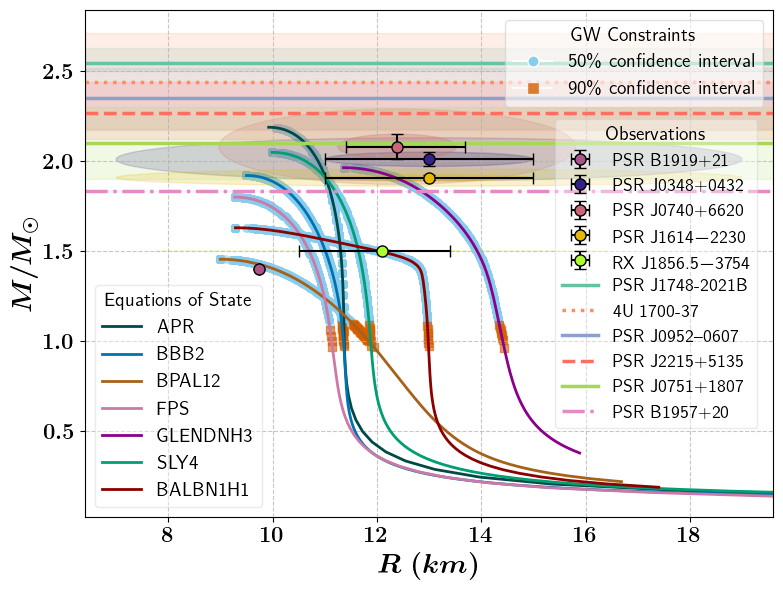

In [3]:
# Define eos_name names and colors
eos_names = ["apr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#009E73", "#8B0000"]

# Columns in MoIL.dat
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']
mass50, mass90 = [], []

# Extract masses from MoIL.dat using tidal deformability limits
for eos_name in eos_names:
    df = pd.read_csv(f'../output/{eos_name}/1000_MoIL.dat', names=cols)
    df = df.iloc[:df['M'].idxmax() + 1]

    for _, row in df.iterrows():
        if row['L'] <= 940.45:
            mass50.append(row['M'])
        elif 940.45 < row['L'] <= 1913.8:
            mass90.append(row['M'])

mass50 = np.array(mass50)
mass90 = np.array(mass90)


# Define Lorene data directory and eos_name mapping
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_300Hz_extracted_data.csv",
    "BBB2": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_300Hz_extracted_data.csv",
    "BPAL12": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_300Hz_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "GLENDNH3": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_300Hz_extracted_data.csv",
    "SLY4": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "BALBN1H1": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_300Hz_extracted_data.csv"
}

#cols = ["Gravitational mass", "Mean radius"]

mass50_nearest, mass90_nearest = {}, {}
radius50_nearest, radius90_nearest = {}, {}

# Folder path for LSODA results
lsoda_folder = "/home/sanjana/ashoka/thesis/output_lsoda"

plt.figure(figsize=(8, 6))
eos_handles = []
                           
# Loop over LSODA files in the folder and plot them
lsoda_markers = ["o", "o", "o", "o", "o", "o", "o"]  # Use the same markers
eos_names = ["apr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
    
# Iterate over the eos_names and construct the correct file names
for eos_name, marker, color in zip(eos_names, lsoda_markers, colors):
    # Construct the file name corresponding to each eos_name name
    lsoda_file = f"{eos_name}_cspline_LSODA.csv"
    
    # Construct the full path for each file
    file_path = os.path.join(lsoda_folder, lsoda_file)
    
    df_lsoda = pd.read_csv(file_path)
    
    # Assuming the columns are "Radius" and "Mass"
    # Filter out invalid values
    df_lsoda = df_lsoda[(df_lsoda["Radius (km)"] != "N/A") & (df_lsoda["Mass (M_sun)"] != "N/A")]
    df_lsoda["Radius (km)"] = pd.to_numeric(df_lsoda["Radius (km)"])
    df_lsoda["Mass (M_sun)"] = pd.to_numeric(df_lsoda["Mass (M_sun)"])

    # Filter out invalid entries (NaN values)
    df_lsoda = df_lsoda.dropna(subset=["Radius (km)", "Mass (M_sun)"])

    # Extract raw mass and radius values
    mass_values_raw = df_lsoda["Mass (M_sun)"].values
    radius_values_raw = df_lsoda["Radius (km)"].values

    # Apply the filtering logic to keep only increasing mass values
    valid_indices = [0]
    for i in range(1, len(mass_values_raw)):
        if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
            valid_indices.append(i)

    # Apply the filter to both mass and radius values
    mass_values = mass_values_raw[valid_indices]
    radius_values = radius_values_raw[valid_indices]

    # Plot the data for LSODA
    #line2 = plt.scatter(radius_values, mass_values, label=f"{eos_name.upper()}",marker=marker, color=color, s=30, edgecolor="black")
    line2, = plt.plot(radius_values, mass_values, label=f"{eos_name.upper()}", color=color, linewidth=2)
    eos_handles.append(line2)

    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]
    nearest_mass90 = np.array(list(set(nearest_mass90) - set(nearest_mass50)))

    corresponding_radius50 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_radius90 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    mass50_nearest[eos_name] = np.array(nearest_mass50)
    mass90_nearest[eos_name] = np.array(nearest_mass90)
    radius50_nearest[eos_name] = np.array(corresponding_radius50)
    radius90_nearest[eos_name] = np.array(corresponding_radius90)

# GW constraints
for eos_name in eos_names:
    if eos_name in mass50_nearest:
        plt.scatter(radius50_nearest[eos_name], mass50_nearest[eos_name],
                    color="#88CCEE", marker="o", alpha=0.4, s=30)

    if eos_name in mass90_nearest:
        # Convert 50% masses to a set for fast comparison
        mass50_set = set(np.round(mass50_nearest[eos_name], 5))

        # Filter 90% points: not in 50% and > 1.2 M_sun
        unique_mass90 = []
        unique_radius90 = []
        for m, r in zip(mass90_nearest[eos_name], radius90_nearest[eos_name]):
            if (np.round(m, 5) not in mass50_set):# and (m < 1.2):
                unique_mass90.append(m)
                unique_radius90.append(r)

        plt.scatter(unique_radius90, unique_mass90,
                    color="#D55E00", marker="s", alpha=0.6, s=30)
        
masses_ns = np.array([1.4, 2.01, 2.08, 1.908, 1.5])
radii_ns = np.array([9.7398, 13.0, 12.39, 13.0, 12.1])
spin_s_ns = np.array([1.3373, 0.0391226569017806, 0, 0.0031508076534271, 0])
labels_ns = np.array([
    "PSR B1919+21",
    "PSR J0348+0432",
    "PSR J0740+6620",
    "PSR J1614−2230",
    "RX J1856.5−3754"
])

freq_ns = np.where(spin_s_ns != 0, 1 / spin_s_ns, 0)
omega_ns = 2 * np.pi * freq_ns

num_stars = len(labels_ns)
colors_ns = np.array(["#AA5588","#332288","#CC6677","#E6B800", "#ADFF2F"])

mass_errors_ns = np.array([
    [0.0, 0.04, 0.07, 0.016, 0.0],
    [0.0, 0.04, 0.07, 0.016, 0.0]
])

radius_errors_ns = np.array([
    [0.0, 2.0, 0.98, 2.0, 1.6],
    [0.0, 2.0, 1.30, 2.0, 1.3]
])

obs_handles = []
obs_labels = []

for i, (radius, mass, label, freq) in enumerate(zip(radii_ns, masses_ns, labels_ns, freq_ns)):
    label_with_freq = f"{label}"# ({freq:.2f} Hz)" if freq > 0 else f"{label}"
    color = colors_ns[i]

    err = plt.errorbar(
        radius, mass,
        xerr=[[radius_errors_ns[0][i]], [radius_errors_ns[1][i]]],
        yerr=[[mass_errors_ns[0][i]], [mass_errors_ns[1][i]]],
        fmt='o',
        color=color,             # Color of the point
        ecolor='black',          # Color of the error bars
        markersize=8,
        markeredgecolor='black',
        markeredgewidth=1,
        capsize=4,
        label=label_with_freq,
        zorder=10
    )
    obs_handles.append(err)
    obs_labels.append(label_with_freq)

    # Draw 1σ and 3σ ellipses
    for nsigma, alpha in zip([1, 3], [0.3, 0.2]):
        width = 2 * nsigma * np.mean([radius_errors_ns[0][i], radius_errors_ns[1][i]])
        height = 2 * nsigma * np.mean([mass_errors_ns[0][i], mass_errors_ns[1][i]])
        ellipse = Ellipse(
            (radius, mass),
            width=width,
            height=height,
            edgecolor=color,
            facecolor=color,
            lw=1,
            alpha=alpha,
            zorder=1
        )
        plt.gca().add_patch(ellipse)


# Neutron Star Names
names = [
    "PSR J1748-2021B", "4U 1700-37", "PSR J2017-1614", "PSR J0952–0607", 
    "PSR J1311–3430", "PSR J1600−3053", "PSR J2215+5135", "XMMU J013236.7+303228", 
    "PSR J0751+1807", "PSR J0740+6620", "PSR J0348+0432", "PSR J1518+0204B (M5B)", 
    "PSR B1516+02B", "Vela X-1", "PSR J2222–0137", "PSR B1957+20", 
    "SWIFT J1756.9-2508"
]

# Masses and uncertainties (mass, lower uncertainty, upper uncertainty)
masses = [
    2.548, 2.44, 2.4, 2.35, 2.15, 2.3, 2.27, 2.2, 2.1, 2.08, 2.01, 1.981, 1.94, 
    1.908, 1.88, 1.831, 1.81, 1.8
]
lower_uncertainty = [
    0.047, 0.27, 0.6, 0.17, 0.55, 0.6, 0.15, 0.8, 0.2, 0.07, 0.04, 0.0, 0.17, 
    0.016, 0.13, 0.0, 0.17, 0.4
]
upper_uncertainty = [
    0.078, 0.27, 0.6, 0.17, 0.55, 0.7, 0.17, 0.8, 0.2, 0.07, 0.04, 0.0, 0.19, 
    0.016, 0.13, 0.0, 0.17, 0.4
]

# List of neutron stars to be removed
remove_ns = [
    "SWIFT J1756.9-2508", "PSR J2222–0137", "Vela X-1", "PSR B1516+02B",
    "PSR J0348+0432", "PSR J0740+6620", "PSR J1311–3430", "PSR J2017-1614", "XMMU J013236.7+303228", "PSR J1600−3053", "PSR J1518+0204B (M5B)", "PSR J1614−2230"
]

# Using list comprehension to filter out the unwanted neutron stars
filtered_names = [name for name in names if name not in remove_ns]
filtered_masses = [mass for name, mass in zip(names, masses) if name not in remove_ns]
filtered_lower_uncertainty = [low for name, low in zip(names, lower_uncertainty) if name not in remove_ns]
filtered_upper_uncertainty = [high for name, high in zip(names, upper_uncertainty) if name not in remove_ns]

# Color palette that is color-blind friendly
colors_line = np.array(["#66C2A5", "#FC8D62", "#8DA0CB", "#FF6F61", "#A6D854", "#E78AC3"])
linestyles = np.array(['solid','dotted','solid','dashed','solid','dashdot'])

# Loop over each mass and draw shaded ±1σ and ±3σ regions along with the central line
for i, (name, mass, low, high) in enumerate(zip(filtered_names, filtered_masses, filtered_lower_uncertainty, filtered_upper_uncertainty)):
    color = colors_line[i]
    linestyle = linestyles[i]
    # ±3σ region (shaded)
    #plt.axhspan(mass - 3*low, mass + 3*high, color=color, alpha=0.2)

    # ±1σ region (shaded)
    plt.axhspan(mass - low, mass + high, color=color, alpha=0.15)

    # Central line at the mass value
    line = plt.axhline(mass, color=color, linestyle=linestyle, linewidth=2.5, label=f'{name}')

    # Add the line to the legend
    obs_handles.append(line)
    obs_labels.append(name)



# Final formatting
plt.ylabel(r'$M/M_\odot$', fontsize=20)
plt.xlabel(r'$R \ (km)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)

# TWO LEGENDS
first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=14, loc='lower left', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)

# Add second legend for GW constraints
gw_handles = [
    Line2D([0], [0], marker='o', color='w', label='50\% confidence interval',
           markerfacecolor='#88CCEE', markersize=8),
    Line2D([0], [0], marker='s', color='w', label='90\% confidence interval',
           markerfacecolor='#D55E00', markersize=8, alpha=0.8)
]
# Add second legend for GW constraints
second_legend = plt.legend(handles=gw_handles, title="GW Constraints",
                           loc='upper right', fontsize=14, title_fontsize=14,framealpha=0.6)
plt.gca().add_artist(second_legend)

third_legend = plt.legend(handles=obs_handles, labels=obs_labels, title="Observations", fontsize=13 , loc='center left', bbox_to_anchor=(0.67, 0.48), title_fontsize=14,framealpha=0.4)

plt.xlim(6.4, 19.6)
plt.ylim(0.02, 2.84)

plt.tight_layout()
#plt.savefig("/home/sanjana/ashoka/thesis/finalplots/Mass_Radius_with_obs_constraints.png", dpi=300)
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/Mass_Radius_with_obs_constraints_highrot.pdf")
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/Mass_Radius_with_obs_constraints_highrot.png",dpi=600)
plt.show()

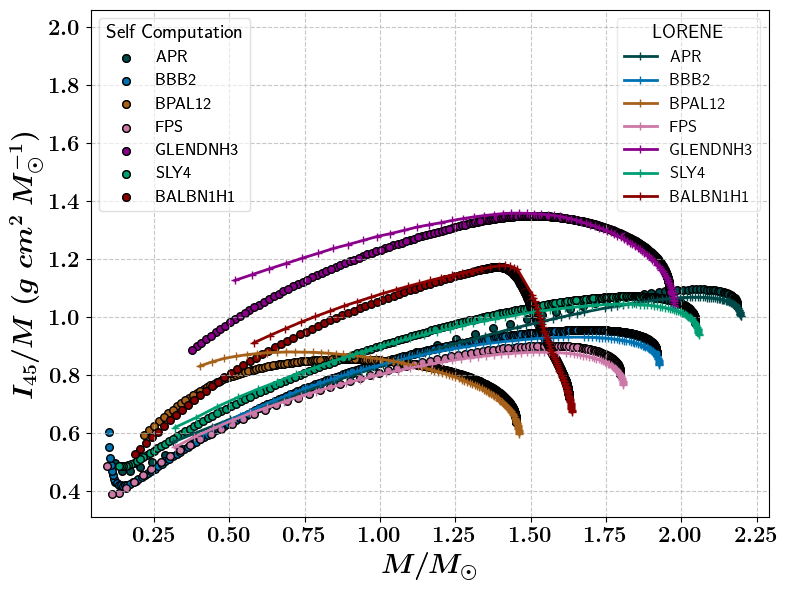

In [8]:
# -------------------------------------------------------------------------------------------------
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define EOS names and their plotting colors
eos_names = ["apr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#009E73", "#8B0000"]

# Column names in MoIL.dat
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']  

# -------------------------------------------------------------------------------------------------

# Initialize plot
plt.figure(figsize=(8, 6))

eos_handles2 = []
for i, eos_name in enumerate(eos_names):
    #df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)
    df = pd.read_csv(f'../output/{eos_name}/363Hz_MoIL.dat', names=cols)

    # Find index of maximum mass and truncate data
    max_mass_idx = df['M'].idxmax()
    df = df.iloc[:max_mass_idx + 1]

    # Plot the main scatter plot
    line = plt.scatter(df.M, df.I / (1e38 * df.M), color=colors[i % len(colors)], s=30, edgecolor='k', label=eos_name.upper())
    eos_handles2.append(line)

# Base directory for LORENE output
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"
# Required column names from CSVs
cols = ["Gravitational mass", "Moment of inertia"]

# EOS mapping to stationary neutron star CSV files at 300Hz
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_363Hz_nrot_extracted_data.csv",
    "BBB2": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_363Hz_nrot_extracted_data.csv",
    "BPAL12": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_363Hz_nrot_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_363Hz_nrot_extracted_data.csv",
    "GLENDNH3": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_363Hz_nrot_extracted_data.csv",
    "SLY4": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_363Hz_nrot_extracted_data.csv",
    "BALBN1H1": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_363Hz_nrot_extracted_data.csv"
}

eos_handles = []

# Loop over each EOS to extract MoI data and match constrained masses
for eos, file in eos_files_stationary.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue

    # Read the required columns
    df = pd.read_csv(file, usecols=cols).dropna()

    # Enforce monotonic increase in gravitational mass only
    mass_values_raw = df["Gravitational mass"].values
    moi_values_raw = df["Moment of inertia"].values

    # Identify valid (monotonically increasing) indices
    valid_indices = [0]
    for i in range(1, len(mass_values_raw)):
        if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
            valid_indices.append(i)

    # Filtered values
    mass_values = mass_values_raw[valid_indices]
    moi_values = moi_values_raw[valid_indices] / mass_values  # MoI / M only after filtering masses

    color = colors[list(eos_files_stationary.keys()).index(eos)]
    line, = plt.plot(mass_values, moi_values, linestyle="-", color=color, marker = '+', linewidth=2, label=eos)
    eos_handles.append(line)

# --- Final plot formatting ---
plt.xlabel(r'$M/M_\odot$', fontsize=20)
plt.ylabel(r'$I_{45}/M \ (g \ cm^2 \ M_{\odot}^{-1})$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)

first_legend = plt.legend(handles=eos_handles, title="LORENE", fontsize=12, loc='upper right', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)

second_legend = plt.legend(handles=eos_handles2, title="Self Computation", fontsize=12, loc='upper left', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(second_legend)

plt.xlim(0.04, 2.29)
plt.ylim(0.31, 2.06)
plt.tight_layout()
#plt.savefig("MOI_with_obs_constraints.png", dpi=300)
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/MOI_comp.pdf")
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/MOI_comp.png",dpi=600)
plt.show()

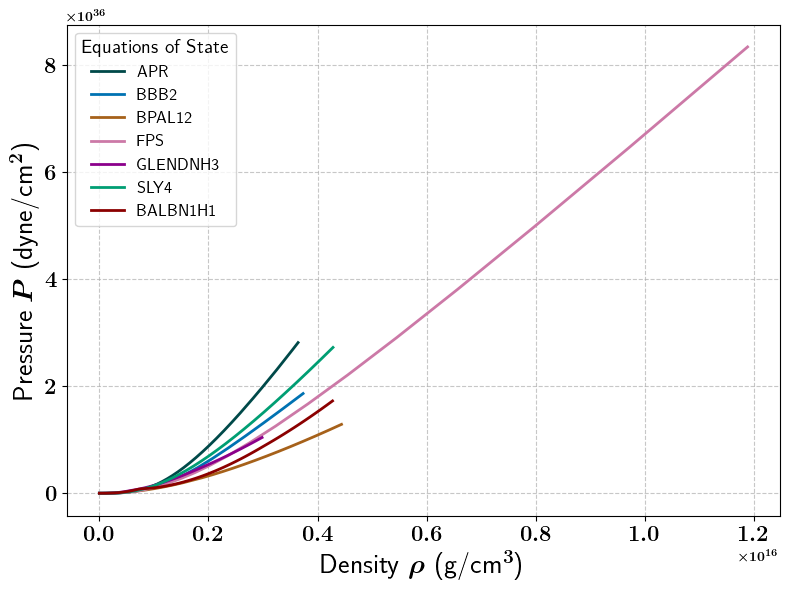

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os

# EOS names and colors
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["#004949", "#0072B2", "#A6611A", "#CC79A7", "#8B008B", "#009E73", "#8B0000"]

# Source directory
source_dir = '/home/sanjana/ashoka/thesis/EoS/'

plt.figure(figsize=(8,6))

for i, (eos_name, color) in enumerate(zip(eos_names, colors)):
    file_path = os.path.join(source_dir, f"eos_{eos_name}.txt")
    data = np.genfromtxt(file_path)

    # Assuming pressure is column 3 and density is column 2 (0-based indexing)
    rho = data[:, 2]
    P = data[:, 3]

    # Filter out non-physical entries
    valid = (rho > 0) & (P > 0)
    rho = rho[valid]
    P = P[valid]

    label = "APR" if i == 0 else eos_name.upper()
    plt.plot(rho, P, label=label, color=color, linewidth=2)


#plt.xscale("log")
#plt.yscale("log")
plt.xlabel(r'Density $\rho$ (g/cm$^3$)', fontsize=20)
plt.ylabel(r'Pressure $P$ (dyne/cm$^2$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title="Equations of State", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/P_vs_rho_all_EoS.pdf")
plt.show()

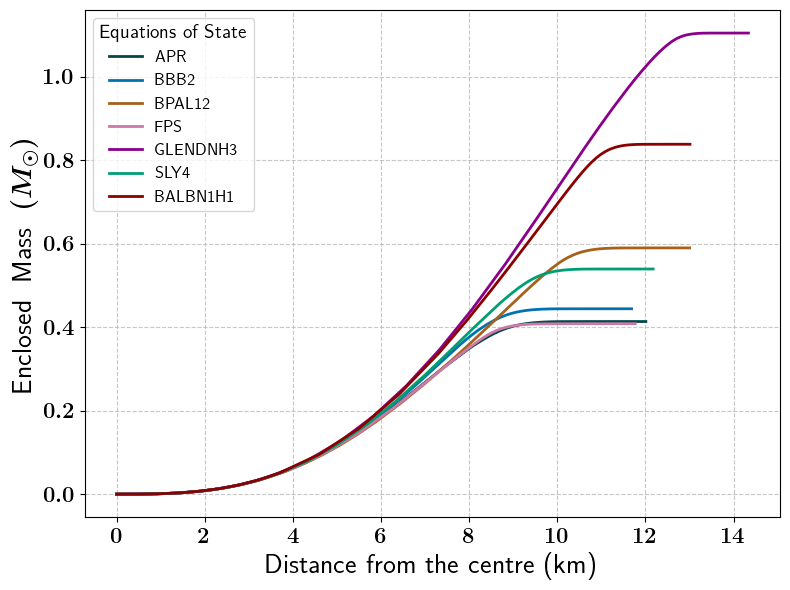

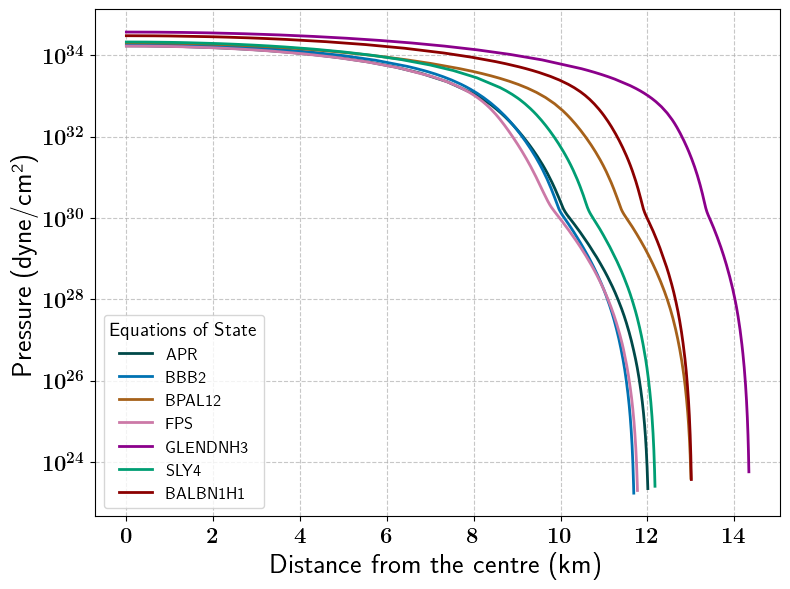

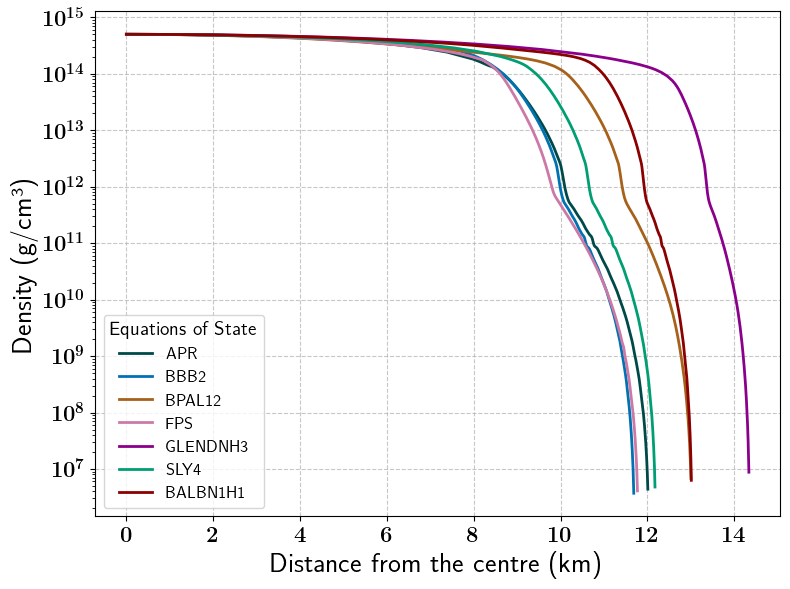

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from tqdm import tqdm
from scipy.integrate import solve_ivp
import pandas as pd
import os
import re
import csv

G = 6.6743e-8  # cm^3/g/s^2
c = 29979245800     # cm/s

# Array of EOS names
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
source_dir = '/home/sanjana/ashoka/thesis/EoS/'  # Directory containing EOS files

colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#009E73", "#8B0000"]

eos_labels = {
    "akmalpr": "APR",
    "bbb2": "BBB2",
    "bpal12": "BPAL12",
    "fps": "FPS",
    "glendnh3": "GLENDNH3",
    "sly4": "SLY4",
    "balbn1h1": "BALBN1H1"
}

eos_results = {}

# Loop over each EOS
for eos_name in eos_names:
    data = np.genfromtxt(f"{source_dir}eos_{eos_name}.txt", delimiter=None)
    baryon_density = data[:, 1]
    density = data[:, 2]
    pressure = data[:, 3]

    min_density = 2.4e14 #np.min(density) #1e14  # Lower bound on central density
    max_density = np.max(density)
    
    valid_indices = (density > 0) & (pressure > 0)
    density = density[valid_indices]
    pressure = pressure[valid_indices]
    baryon_density = baryon_density[valid_indices]
    
    log_density = np.log(density)
    log_pressure = np.log(pressure)
    #'''
    log_pressure_to_log_density = CubicSpline(log_pressure, log_density)
    log_density_to_log_pressure = CubicSpline(log_density, log_pressure)

    '''
    log_pressure_to_log_density = interp1d(log_pressure, log_density, kind='linear', bounds_error=True)
    log_density_to_log_pressure = interp1d(log_density, log_pressure, kind='linear', bounds_error=True)
    '''
    
    def pressure_to_density(pressure):
        log_pressure = np.log(pressure)
        # Determine the valid range
        min_log_p, max_log_p = log_pressure_to_log_density.x[0], log_pressure_to_log_density.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_pressure < min_log_p or log_pressure > max_log_p:
            clipped_value = np.exp(np.clip(log_pressure, min_log_p, max_log_p))
            print(f"Warning: Extrapolation detected for pressure {pressure:.4e}, clipping to {clipped_value:.4e}.")
            log_pressure = np.clip(log_pressure, min_log_p, max_log_p)
    
        log_density = log_pressure_to_log_density(log_pressure)
        return np.exp(log_density)
    
    def density_to_pressure(density):
        log_density = np.log(density)
        # Determine the valid range
        min_log_rho, max_log_rho = log_density_to_log_pressure.x[0], log_density_to_log_pressure.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_density < min_log_rho or log_density > max_log_rho:
            clipped_value = np.exp(np.clip(log_density, min_log_rho, max_log_rho))
            print(f"Warning: Extrapolation detected for density {density:.4e}, clipping to {clipped_value:.4e}.")
            log_density = np.clip(log_density, min_log_rho, max_log_rho)
    
        log_pressure = log_density_to_log_pressure(log_density)
        return np.exp(log_pressure)

    # TOV equations
    def compute_derivatives(r, state_vars, eos_type):
        mass, pressure = state_vars

        if pressure <= 1e-10 * density_to_pressure(min_density):  # Stop condition
            return [0, 0]

        density = pressure_to_density(pressure)
        dm_dr = 4.0 * np.pi * (r**2) * density
        dP_dr = -(((G * mass * density) / (r**2)) * (1 + (pressure / (density * c * c))) *
                  (1 + ((4 * np.pi * pressure * (r**3)) / (mass * c * c)))) / (1 - ((2 * G * mass) / (r * c * c)))
        return [dm_dr, dP_dr]

    # Stopping condition for solve_ivp
    def pressure_stop_condition(r, y, eos_type):
        return y[1] - 1e-10 * density_to_pressure(min_density)  # Stop when P < threshold

    pressure_stop_condition.terminal = True  # Stop integration
    pressure_stop_condition.direction = -1  # Stop when pressure is decreasing

    # Solve the neutron star structure
    def solve_neutron_star_structure(central_density, eos_type):
        initial_pressure = density_to_pressure(central_density)
        state_variables_initial = [1e-10, initial_pressure]  # Small initial mass

        sol = solve_ivp(compute_derivatives, [1e-2, 2e6], state_variables_initial, method="LSODA",
                        rtol=1e-5, atol=1e-5, args=(eos_type,), events=pressure_stop_condition)

        final_radius = sol.t[-1]
        final_mass = sol.y[0, -1]
        radii = sol.t
        mass_profile = sol.y[0]
        pressure_profile = sol.y[1]
        density_profile = np.array([pressure_to_density(p) for p in pressure_profile])
        return final_radius, final_mass, radii, mass_profile, pressure_profile, density_profile


    # Compute for fixed central density
    central_density = 5e14
    R, M, radii, mass_profile, pressure_profile, density_profile = solve_neutron_star_structure(central_density, eos_name)

    # Store results
    eos_results[eos_name] = {
        "central_density": central_density,
        "R": R / 1e5,
        "M": M / 1.989e33,
        "radii": radii / 1e5,  # Convert to km
        "mass_profile": mass_profile / 1.989e33,
        "pressure_profile": pressure_profile,
        "density_profile": density_profile
    }

# Plotting Mass Profile vs Radius
plt.figure(figsize=(8, 6))
for i, eos_name in enumerate(eos_names):
    res = eos_results[eos_name]
    plt.plot(res["radii"], res["mass_profile"], linewidth=2, label=eos_labels[eos_name], color=colors[i])
plt.xlabel("Distance from the centre (km)", fontsize=20)
plt.ylabel(r"Enclosed \ Mass \ $(M_\odot)$", fontsize=20)
plt.legend(title="Equations of State", fontsize=12, title_fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/mass_profile_vs_radius.pdf')
plt.show()

# Plotting Pressure Profile vs Radius
plt.figure(figsize=(8, 6))
for i, eos_name in enumerate(eos_names):
    res = eos_results[eos_name]
    plt.plot(res["radii"], res["pressure_profile"], linewidth=2, label=eos_labels[eos_name], color=colors[i])
plt.xlabel("Distance from the centre (km)", fontsize=20)
plt.ylabel(r"Pressure (dyne/cm²)", fontsize=20)
plt.yscale("log")
plt.legend(title="Equations of State", fontsize=12, title_fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/pressure_vs_radius.pdf')
plt.show()

# Plotting Density Profile vs Radius
plt.figure(figsize=(8, 6))
for i, eos_name in enumerate(eos_names):
    res = eos_results[eos_name]
    plt.plot(res["radii"], res["density_profile"], linewidth=2, label=eos_labels[eos_name], color=colors[i])
plt.xlabel("Distance from the centre (km)", fontsize=20)
plt.ylabel(r"Density (g/cm³)", fontsize=20)
plt.yscale("log")
plt.legend(title="Equations of State", fontsize=12, title_fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/density_vs_radius.pdf')
plt.show()

In [3]:
import numpy as np
from numba import njit

# Constants in cgs units
hbar = 1.054571817e-27  # hbar in erg*s
m_N = 1.67262192369e-24  # Mass of baryon in grams
c = 29979245800     # cm/s

#'''
# Function for calculating pressure for a non-relativistic degenerate Fermi gas
@njit
def pressure_eos(density):
    factor_NR = (3 * np.pi**2 / m_N**4)**(2 / 3)  # Non-relativistic factor
    return (hbar**2 / 5) * factor_NR * density**(5 / 3)
#'''
'''
@njit
def pressure_eos(density):
    factor_UR = (3 * np.pi**2 / m_N**4)**(1 / 3)
    
    return (hbar * c / 4) * factor_UR * density**(4 / 3)
'''  
# Range for density in g/cc
density_range = np.linspace(1.01, 1e17, 10000)

# Specify the file path
file_path = "/home/sanjana/ashoka/thesis/EoS/eos_nonrel_fermi_gas.txt"

# Open file to write data
with open(file_path, "w") as file:
    # Write header
    file.write("Serial No.    n_b        Density (g/cc)    Pressure (dyne/cm^2)\n")
    
    # Loop over density values to calculate corresponding n_b and pressure
    for i, density in enumerate(density_range, 1):
        n_b = (density * m_N) / m_N  # n_b assuming baryon mass in grams
        pressure = pressure_eos(density)
        
        # Write data row to file with 4 spaces as delimiter
        file.write(f"{i}    {n_b:.4e}    {density:.4e}    {pressure:.4e}\n")

print(f"Data file has been saved at: {file_path}")

Data file has been saved at: /home/sanjana/ashoka/thesis/EoS/eos_nonrel_fermi_gas.txt


<>:183: SyntaxWarning: invalid escape sequence '\ '
<>:183: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_77533/1362791965.py:183: SyntaxWarning: invalid escape sequence '\ '
  '''
Processing nonrel_fermi_gas:   3%|▎          | 34/1000 [00:00<00:09, 106.77it/s]/tmp/ipykernel_77533/1362791965.py:44: RuntimeWarning: invalid value encountered in log
  log_pressure = np.log(pressure)
/home/sanjana/miniconda3/lib/python3.12/site-packages/scipy/integrate/_ivp/lsoda.py:161: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  solver._y, solver.t = integrator.run(
Processing nonrel_fermi_gas:   6%|▋          | 57/1000 [00:00<00:08, 109.12it/s]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.8918686364788D+06   r2 =                  NaN


Processing nonrel_fermi_gas:  12%|█▏        | 123/1000 [00:01<00:08, 103.72it/s]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6685337078685D+06   r2 =                  NaN


Processing nonrel_fermi_gas:  18%|█▊        | 181/1000 [00:01<00:07, 109.56it/s]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6051475059260D+06   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.5859140466946D+06   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.5779409669112D+06   r2 =                  NaN


Processing nonrel_fermi_gas:  25%|██▍       | 247/1000 [00:02<00:07, 104.84it/s]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.5431965145147D+06   r2 =                  NaN


Processing nonrel_fermi_gas:  65%|███████▏   | 650/1000 [00:06<00:03, 96.73it/s]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4321856359735D+06   r2 =                  NaN


Processing nonrel_fermi_gas:  73%|████████   | 732/1000 [00:07<00:02, 98.27it/s]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4260278419149D+06   r2 =                  NaN


Processing nonrel_fermi_gas:  87%|█████████▌ | 873/1000 [00:08<00:01, 95.74it/s]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4141549327059D+06   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4136043584356D+06   r2 =                  NaN


Processing nonrel_fermi_gas:  95%|██████████▍| 954/1000 [00:09<00:00, 98.21it/s]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4122210591985D+06   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4104743549265D+06   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4106342790440D+06   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4134800494385D+06   r2 =                  NaN


Processing nonrel_fermi_gas:  98%|██████████▊| 984/1000 [00:09<00:00, 89.96it/s]

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.4090492981286D+06   r2 =                  NaN


Processing nonrel_fermi_gas: 100%|█████████| 1000/1000 [00:09<00:00, 100.91it/s]


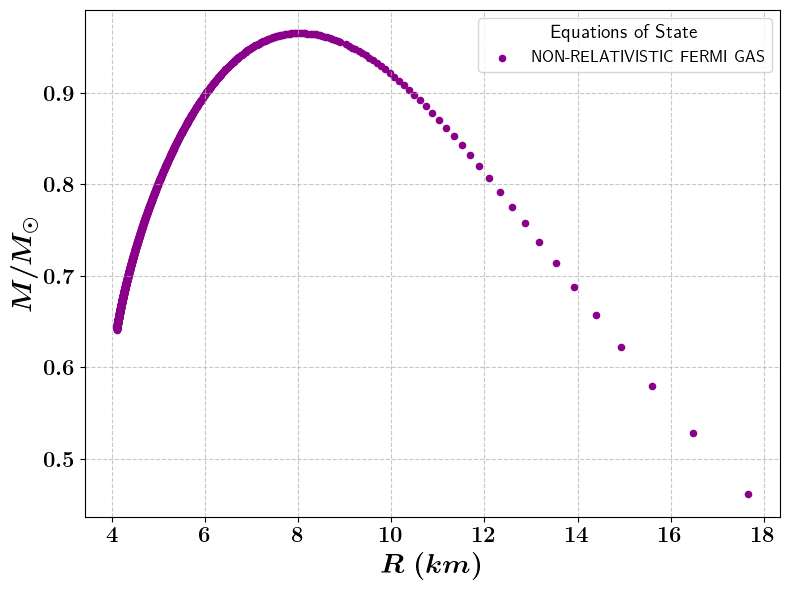

'\n# Plotting Mass Profile vs Radius\nplt.figure(figsize=(8, 6))\nfor i, eos_name in enumerate(eos_names):\n    res = eos_results[eos_name]\n    plt.plot(res["radii"], res["mass_profile"], linewidth=2, label=eos_labels[eos_name], color=colors[i])\nplt.xlabel("Distance from the centre (km)", fontsize=20)\nplt.ylabel(r"Enclosed \\ Mass \\ $(M_\\odot)$", fontsize=20)\nplt.legend(title="Equations of State", fontsize=12, title_fontsize=14)\nplt.xticks(fontsize=16)\nplt.yticks(fontsize=16)\nplt.grid(linestyle=\'--\', alpha=0.7)\nplt.tight_layout()\nplt.savefig(\'/home/sanjana/ashoka/thesis/finalplots/mass_profile_vs_radius_poly.pdf\')\nplt.show()\n\n# Plotting Pressure Profile vs Radius\nplt.figure(figsize=(8, 6))\nfor i, eos_name in enumerate(eos_names):\n    res = eos_results[eos_name]\n    plt.plot(res["radii"], res["pressure_profile"], linewidth=2, label=eos_labels[eos_name], color=colors[i])\nplt.xlabel("Distance from the centre (km)", fontsize=20)\nplt.ylabel(r"Pressure (dyne/cm²)", fo

In [17]:
G = 6.6743e-8  # cm^3/g/s^2
c = 29979245800     # cm/s

# Array of EOS names
eos_names = ["nonrel_fermi_gas"]#, "urel_fermi_gas"]
source_dir = '/home/sanjana/ashoka/thesis/EoS/'  # Directory containing EOS files

colors = ["#8B008B"]#,  "#009E73"]#, "#8B0000"]
markers = ['o']#, 'o']
eos_labels = {
    "nonrel_fermi_gas": "NON-RELATIVISTIC FERMI GAS"#,
   # "urel_fermi_gas": "ULTRA-RELATIVISTIC FERMI GAS"
}

eos_results = {}

# Loop over each EOS
for eos_name in eos_names:
    data = np.genfromtxt(f"{source_dir}eos_{eos_name}.txt", delimiter=None)
    baryon_density = data[:, 1]
    density = data[:, 2]
    pressure = data[:, 3]

    min_density = 2.4e14 #np.min(density) #1e14  # Lower bound on central density
    max_density = np.max(density)
    
    valid_indices = (density > 0) & (pressure > 0)
    density = density[valid_indices]
    pressure = pressure[valid_indices]
    baryon_density = baryon_density[valid_indices]
    
    log_density = np.log(density)
    log_pressure = np.log(pressure)
    #'''
    log_pressure_to_log_density = CubicSpline(log_pressure, log_density)
    log_density_to_log_pressure = CubicSpline(log_density, log_pressure)

    '''
    log_pressure_to_log_density = interp1d(log_pressure, log_density, kind='linear', bounds_error=True)
    log_density_to_log_pressure = interp1d(log_density, log_pressure, kind='linear', bounds_error=True)
    '''
    
    def pressure_to_density(pressure):
        log_pressure = np.log(pressure)
        # Determine the valid range
        min_log_p, max_log_p = log_pressure_to_log_density.x[0], log_pressure_to_log_density.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_pressure < min_log_p or log_pressure > max_log_p:
            clipped_value = np.exp(np.clip(log_pressure, min_log_p, max_log_p))
            print(f"Warning: Extrapolation detected for pressure {pressure:.4e}, clipping to {clipped_value:.4e}.")
            log_pressure = np.clip(log_pressure, min_log_p, max_log_p)
    
        log_density = log_pressure_to_log_density(log_pressure)
        return np.exp(log_density)
    
    def density_to_pressure(density):
        log_density = np.log(density)
        # Determine the valid range
        min_log_rho, max_log_rho = log_density_to_log_pressure.x[0], log_density_to_log_pressure.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_density < min_log_rho or log_density > max_log_rho:
            clipped_value = np.exp(np.clip(log_density, min_log_rho, max_log_rho))
            print(f"Warning: Extrapolation detected for density {density:.4e}, clipping to {clipped_value:.4e}.")
            log_density = np.clip(log_density, min_log_rho, max_log_rho)
    
        log_pressure = log_density_to_log_pressure(log_density)
        return np.exp(log_pressure)
    #'''
    # TOV equations
    def TOV(r, state_vars):
        mass, pressure = state_vars
        
        density = pressure_to_density(pressure)
        dm_dr = 4.0 * np.pi * (r**2) * density
        dP_dr = -(((G * mass * density) / (r**2)) * (1 + (pressure / (density * c * c))) *
                  (1 + ((4 * np.pi * pressure * (r**3)) / (mass * c * c)))) / (1 - ((2 * G * mass) / (r * c * c)))
        return [dm_dr, dP_dr]
    
    # Stopping condition for solve_ivp
    def pressure_stop_condition(r, y):
        return y[1] - 1e-18 * density_to_pressure(min_density)  # Stop when P < threshold

    pressure_stop_condition.terminal = True  # Stop integration
    pressure_stop_condition.direction = -1  # Stop when pressure is decreasing

    # Solve the neutron star structure
    def solve_neutron_star_structure(central_density):
        initial_pressure = density_to_pressure(central_density)
        state_variables_initial = [1e-20, initial_pressure]  # Small initial mass

        sol = solve_ivp(TOV, [1e-25, 2e6], state_variables_initial, method="RK45",
                        rtol=1e-4, atol=1e-4, events=pressure_stop_condition)

        final_radius = sol.t[-1]
        final_mass = sol.y[0, -1]
        radii = sol.t
        mass_profile = sol.y[0]
        pressure_profile = sol.y[1]
        density_profile = np.array([pressure_to_density(p) for p in pressure_profile])
        return final_radius, final_mass#, radii, mass_profile, pressure_profile, density_profile
    #'''
    '''
    # TOV equations
    def compute_derivatives(r, state_vars, eos_type):
        mass, pressure = state_vars

        if pressure <= 1e-10 * density_to_pressure(min_density):  # Stop condition
            return [0, 0]

        density = pressure_to_density(pressure)
        dm_dr = 4.0 * np.pi * (r**2) * density
        dP_dr = -(((G * mass * density) / (r**2)) * (1 + (pressure / (density * c * c))) *
                  (1 + ((4 * np.pi * pressure * (r**3)) / (mass * c * c)))) / (1 - ((2 * G * mass) / (r * c * c)))
        return [dm_dr, dP_dr]

    # Stopping condition for solve_ivp
    def pressure_stop_condition(r, y, eos_type):
        return y[1] - 1e-10 * density_to_pressure(min_density)  # Stop when P < threshold

    pressure_stop_condition.terminal = True  # Stop integration
    pressure_stop_condition.direction = -1  # Stop when pressure is decreasing

    # Solve the neutron star structure
    def solve_neutron_star_structure(central_density, eos_type):
        initial_pressure = density_to_pressure(central_density)
        state_variables_initial = [1e-10, initial_pressure]  # Small initial mass

        sol = solve_ivp(compute_derivatives, [1e-2, 2e6], state_variables_initial, method="LSODA",
                        rtol=1e-5, atol=1e-5, args=(eos_type,), events=pressure_stop_condition)

        final_radius = sol.t[-1]
        final_mass = sol.y[0, -1]
        radii = sol.t
        mass_profile = sol.y[0]
        pressure_profile = sol.y[1]
        density_profile = np.array([pressure_to_density(p) for p in pressure_profile])
        return final_radius, final_mass, radii, mass_profile, pressure_profile, density_profile
    '''
    # Compute for fixed central density
    #central_density = 5e14
    #R, M, radii, mass_profile, pressure_profile, density_profile = solve_neutron_star_structure(central_density, eos_name)
    #'''
    central_densities = np.linspace(min_density, max_density, 1000)
    results = np.zeros([2, len(central_densities)])

    for i in tqdm(range(len(central_densities)), desc=f"Processing {eos_name}"):
        results[:, i] = solve_neutron_star_structure(central_densities[i])

    radius = results[0,] / 1e5  # Convert to km
    mass = results[1,] / 1.989e33  # Convert to solar masses
    eos_results[eos_name] = (central_densities, radius, mass)
    #'''
    '''
    # Store results
    eos_results[eos_name] = {
        "central_density": central_density,
        "R": R / 1e5,
        "M": M / 1.989e33,
        "radii": radii / 1e5,  # Convert to km
        "mass_profile": mass_profile / 1.989e33,
        "pressure_profile": pressure_profile,
        "density_profile": density_profile
    }
    '''
#'''
# Plotting Mass vs Radius
plt.figure(figsize=(8, 6))

for eos_name, (central_densities, radius, mass), marker, color in zip(eos_results.keys(), eos_results.values(), markers, colors):
    plt.scatter(radius, mass, label=eos_labels[eos_name], marker=marker, color=color, s=20)
plt.xlabel(r'$R \ (km)$', fontsize=20)
plt.ylabel(r'$M/M_\odot$', fontsize=20)
plt.legend(title="Equations of State", fontsize=12, title_fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/mass_vs_radius_poly.pdf')
plt.show()
#'''
'''
# Plotting Mass Profile vs Radius
plt.figure(figsize=(8, 6))
for i, eos_name in enumerate(eos_names):
    res = eos_results[eos_name]
    plt.plot(res["radii"], res["mass_profile"], linewidth=2, label=eos_labels[eos_name], color=colors[i])
plt.xlabel("Distance from the centre (km)", fontsize=20)
plt.ylabel(r"Enclosed \ Mass \ $(M_\odot)$", fontsize=20)
plt.legend(title="Equations of State", fontsize=12, title_fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/mass_profile_vs_radius_poly.pdf')
plt.show()

# Plotting Pressure Profile vs Radius
plt.figure(figsize=(8, 6))
for i, eos_name in enumerate(eos_names):
    res = eos_results[eos_name]
    plt.plot(res["radii"], res["pressure_profile"], linewidth=2, label=eos_labels[eos_name], color=colors[i])
plt.xlabel("Distance from the centre (km)", fontsize=20)
plt.ylabel(r"Pressure (dyne/cm²)", fontsize=20)
plt.yscale("log")
plt.legend(title="Equations of State", fontsize=12, title_fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/pressure_vs_radius_poly.pdf')
plt.show()

# Plotting Density Profile vs Radius
plt.figure(figsize=(8, 6))
for i, eos_name in enumerate(eos_names):
    res = eos_results[eos_name]
    plt.plot(res["radii"], res["density_profile"], linewidth=2, label=eos_labels[eos_name], color=colors[i])
plt.xlabel("Distance from the centre (km)", fontsize=20)
plt.ylabel(r"Density (g/cm³)", fontsize=20)
plt.yscale("log")
plt.legend(title="Equations of State", fontsize=12, title_fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/density_vs_radius_poly.pdf')
plt.show()
'''


Solving TOV for EOS: nonrel_fermi_gas


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 132.88it/s]



Solving TOV for EOS: urel_fermi_gas


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 229.32it/s]


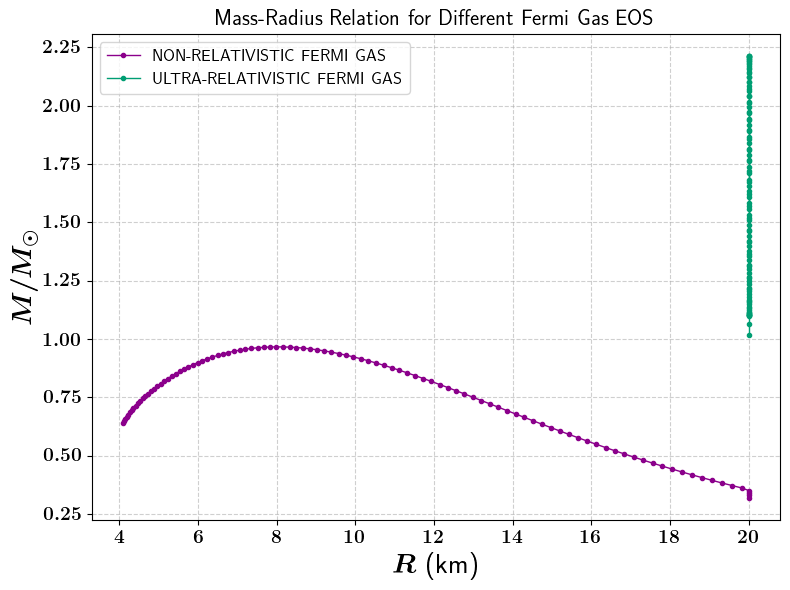

In [16]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
G = 6.6743e-8        # cm^3/g/s^2
c = 2.99792458e10    # cm/s
pi = np.pi
# Constants in cgs units
hbar = 1.054571817e-27  # hbar in erg*s
m_N = 1.67262192369e-24  # Mass of baryon in grams
c = 29979245800     # cm/s

#'''
# Function for calculating pressure for a non-relativistic degenerate Fermi gas
@njit
def pressure_nonrel_fermi(density):
    factor_NR = (3 * np.pi**2 / m_N**4)**(2 / 3)*(hbar**2 / 5)  # Non-relativistic factor
    return factor_NR * density**(5 / 3)
#'''

@njit
def pressure_ultra_fermi(density):
    factor_UR = (3 * np.pi**2 / m_N**4)**(1 / 3)*(hbar * c / 4)
    
    return factor_UR * density**(4 / 3)

def density_nonrel_fermi(pressure):
    factor_NR = (3 * np.pi**2 / m_N**4)**(2 / 3)*(hbar**2 / 5)  # Non-relativistic factor
    return (pressure / factor_NR)**(3/5)

def density_ultra_fermi(pressure):
    factor_UR = (3 * np.pi**2 / m_N**4)**(1 / 3)*(hbar * c / 4)
    return (pressure / factor_UR)**(3/4)

eos_list = {
    "nonrel_fermi_gas": {
        "label": "NON-RELATIVISTIC FERMI GAS",
        "color": "#8B008B",
        "marker": 'o',
        "density_to_pressure": pressure_nonrel_fermi,
        "pressure_to_density": density_nonrel_fermi
    },
    "urel_fermi_gas": {
        "label": "ULTRA-RELATIVISTIC FERMI GAS",
        "color": "#009E73",
        "marker": 'o',
        "density_to_pressure": pressure_ultra_fermi,
        "pressure_to_density": density_ultra_fermi
    }
}

# TOV equations
def make_TOV(density_to_pressure, pressure_to_density):
    def TOV(r, y):
        m, p = y
        if p <= 0:
            return [0, 0]
        rho = pressure_to_density(p)
        dm_dr = 4 * pi * r**2 * rho
        dp_dr = -((G * m * rho) / r**2) * (1 + p / (rho * c**2)) * \
                 (1 + (4 * pi * r**3 * p) / (m * c**2)) / \
                 (1 - (2 * G * m) / (r * c**2))
        return [dm_dr, dp_dr]
    return TOV

# Stopping condition: pressure goes to zero
def make_stop_condition(density_to_pressure, min_density):
    def stop_condition(r, y):
        return y[1] - 1e-18 * density_to_pressure(min_density)
    stop_condition.terminal = True
    stop_condition.direction = -1
    return stop_condition

# Solver for neutron star structure
def solve_star(central_density, density_to_pressure, pressure_to_density):
    p_c = density_to_pressure(central_density)
    y0 = [1e-20, p_c]  # small initial mass
    TOV = make_TOV(density_to_pressure, pressure_to_density)
    stop_cond = make_stop_condition(density_to_pressure, min_density)

    sol = solve_ivp(
        TOV, [1e-6, 2e6], y0,
        rtol=1e-5, atol=1e-5,
        events=stop_cond, method="LSODA"
    )

    R = sol.t[-1]
    M = sol.y[0, -1]
    return R, M

# Density range (in g/cm^3)
min_density = 1e14
max_density = 1e17
central_densities = np.logspace(np.log10(min_density), np.log10(max_density), 100)

# Solve and store results
eos_results = {}

for eos_name, props in eos_list.items():
    radius_arr = []
    mass_arr = []
    print(f"\nSolving TOV for EOS: {eos_name}")
    for rho_c in tqdm(central_densities):
        R, M = solve_star(rho_c, props["density_to_pressure"], props["pressure_to_density"])
        radius_arr.append(R / 1e5)       # cm to km
        mass_arr.append(M / 1.989e33)    # g to solar masses
    eos_results[eos_name] = {
        "radii": np.array(radius_arr),
        "masses": np.array(mass_arr)
    }

# Plot Mass vs Radius
plt.figure(figsize=(8, 6))
for eos_name, results in eos_results.items():
    label = eos_list[eos_name]["label"]
    color = eos_list[eos_name]["color"]
    marker = eos_list[eos_name]["marker"]
    plt.plot(results["radii"], results["masses"], label=label, color=color, marker=marker, markersize=3, linewidth=1)

plt.xlabel(r"$R$ (km)", fontsize=20)
plt.ylabel(r"$M/M_\odot$", fontsize=20)
plt.title("Mass-Radius Relation for Different Fermi Gas EOS", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
#plt.savefig("mass_vs_radius_analytic.pdf")
plt.show()
